###  selective search를 이용하여 Object Detection을 위한 Region Proposal 영역을 도출

#### selectivesearch를 설치하고 이미지를 로드

In [1]:
# pip install selectivesearch

In [2]:
# !mkdir /content/data
# !wget -O /content/data/audrey01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/audrey01.jpg

img shape: (183, 275, 3)


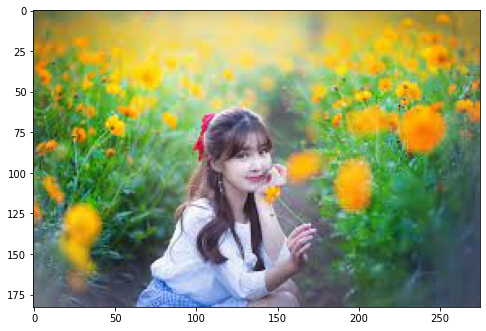

In [1]:
import selectivesearch
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

### 오드리헵번 이미지를 cv2로 로드하고 matplotlib으로 시각화 
img = cv2.imread('people.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('img shape:', img.shape)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.show()

In [2]:
import selectivesearch 

#selectivesearch.selective_search()는 이미지의 Region Proposal정보를 반환 
_, regions = selectivesearch.selective_search(img_rgb, scale=100, min_size=2000)

print(type(regions), len(regions))

<class 'list'> 9


#### 반환된 Region Proposal(후보 영역)에 대한 정보 보기. 
반환된 regions 변수는 리스트 타입으로 세부 원소로 딕셔너리를 가지고 있음. 
개별 딕셔너리내 KEY값별 의미
* rect 키값은 x,y 시작 좌표와 너비, 높이 값을 가지며 이 값이 Detected Object 후보를 나타내는 Bounding box임. 
* size는 Object의 크기
* labels는 해당 rect로 지정된 Bounding Box내에 있는 오브젝트들의 고유 ID
* 아래로 내려갈 수록 너비와 높이 값이 큰 Bounding box이며 하나의 Bounding box에 여러개의 오브젝트가 있을 확률이 커짐. 

In [3]:
regions

[{'rect': (0, 0, 274, 87), 'size': 14517, 'labels': [0.0]},
 {'rect': (76, 18, 83, 57), 'size': 2640, 'labels': [1.0]},
 {'rect': (99, 40, 175, 142), 'size': 20283, 'labels': [2.0]},
 {'rect': (0, 52, 112, 130), 'size': 9956, 'labels': [3.0]},
 {'rect': (64, 116, 80, 66), 'size': 2929, 'labels': [4.0]},
 {'rect': (0, 0, 274, 87), 'size': 17157, 'labels': [0.0, 1.0]},
 {'rect': (0, 40, 274, 142), 'size': 30239, 'labels': [2.0, 3.0]},
 {'rect': (0, 40, 274, 142), 'size': 33168, 'labels': [2.0, 3.0, 4.0]},
 {'rect': (0, 0, 274, 182),
  'size': 50325,
  'labels': [2.0, 3.0, 4.0, 0.0, 1.0]}]

In [4]:
# rect정보만 출력해서 보기
cand_rects = [cand['rect'] for cand in regions]
print(cand_rects)

[(0, 0, 274, 87), (76, 18, 83, 57), (99, 40, 175, 142), (0, 52, 112, 130), (64, 116, 80, 66), (0, 0, 274, 87), (0, 40, 274, 142), (0, 40, 274, 142), (0, 0, 274, 182)]


**bounding box를 시각화 하기**

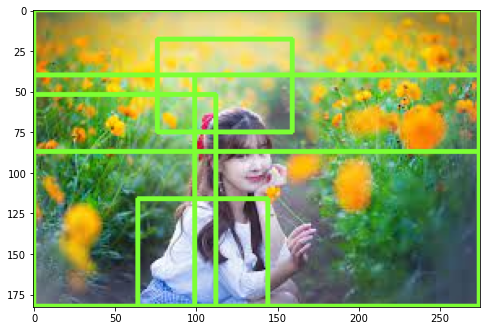

In [5]:
# opencv의 rectangle()을 이용하여 시각화
# rectangle()은 이미지와 좌상단 좌표, 우하단 좌표, box컬러색, 두께등을 인자로 입력하면 원본 이미지에 box를 그려줌. 

green_rgb = (125, 255, 51)
img_rgb_copy = img_rgb.copy()
for rect in cand_rects:
    
    left = rect[0]
    top = rect[1]
    # rect[2], rect[3]은 너비와 높이이므로 우하단 좌표를 구하기 위해 좌상단 좌표에 각각을 더함. 
    right = left + rect[2]
    bottom = top + rect[3]
    
    img_rgb_copy = cv2.rectangle(img_rgb_copy, (left, top), (right, bottom), color=green_rgb, thickness=2)
    
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb_copy)
plt.show()

#### bounding box의 크기가 큰 후보만 추출

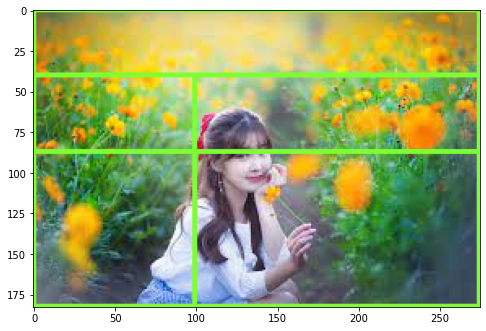

In [6]:
cand_rects = [cand['rect'] for cand in regions if cand['size'] > 10000]

green_rgb = (125, 255, 51)
img_rgb_copy = img_rgb.copy()
for rect in cand_rects:
    
    left = rect[0]
    top = rect[1]
    # rect[2], rect[3]은 너비와 높이이므로 우하단 좌표를 구하기 위해 좌상단 좌표에 각각을 더함. 
    right = left + rect[2]
    bottom = top + rect[3]
    
    img_rgb_copy = cv2.rectangle(img_rgb_copy, (left, top), (right, bottom), color=green_rgb, thickness=2)
    
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb_copy)
plt.show()

### IOU 구하기

#### 입력인자로 후보 박스와 실제 박스를 받아서 IOU를 계산하는 함수 생성

In [8]:
import numpy as np 

def compute_iou(cand_box, gt_box):

    # Calculate intersection areas
    x1 = np.maximum(cand_box[0], gt_box[0])
    y1 = np.maximum(cand_box[1], gt_box[1])
    x2 = np.minimum(cand_box[2], gt_box[2])
    y2 = np.minimum(cand_box[3], gt_box[3])
    
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    
    cand_box_area = (cand_box[2] - cand_box[0]) * (cand_box[3] - cand_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union = cand_box_area + gt_box_area - intersection
    
    iou = intersection / union
    return iou

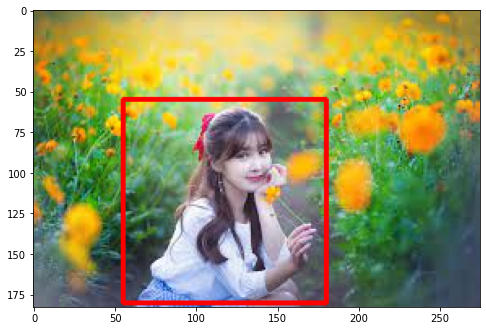

In [11]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 실제 box(Ground Truth)의 좌표를 아래와 같다고 가정. 
gt_box = [55, 55, 180, 180]


img = cv2.imread('people.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

red = (255, 0 , 0)
img_rgb = cv2.rectangle(img_rgb, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), color=red, thickness=2)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.show()

In [12]:
import selectivesearch

#selectivesearch.selective_search()는 이미지의 Region Proposal정보를 반환 
_, regions = selectivesearch.selective_search(img_rgb, scale=100, min_size=2000)

print(type(regions), len(regions))

<class 'list'> 13


In [13]:
cand_rects = [cand['rect'] for cand in regions]
for index, cand_box in enumerate(cand_rects):
    cand_box = list(cand_box)
    cand_box[2] += cand_box[0]
    cand_box[3] += cand_box[1]
    
    iou = compute_iou(cand_box, gt_box)
    print('index:', index, "iou:", iou)

index: 0 iou: 0.11279361588134111
index: 1 iou: 0.2932797050444109
index: 2 iou: 0.968751937503875
index: 3 iou: 0.913792
index: 4 iou: 0.22464
index: 5 iou: 0.2677317173942983
index: 6 iou: 0.308416
index: 7 iou: 0.913792
index: 8 iou: 0.6651279345819046
index: 9 iou: 0.6744216160220995
index: 10 iou: 0.407325338894682
index: 11 iou: 0.407325338894682
index: 12 iou: 0.31332718376513996


In [14]:
cand_rects = [cand['rect'] for cand in regions if cand['size'] > 5000]
cand_rects.sort()
cand_rects

[(0, 0, 274, 87),
 (0, 0, 274, 182),
 (0, 42, 274, 140),
 (0, 42, 274, 140),
 (0, 54, 181, 128),
 (0, 57, 178, 125),
 (0, 72, 109, 110),
 (54, 54, 127, 127),
 (60, 57, 118, 121),
 (60, 57, 118, 121),
 (110, 42, 164, 140)]

img shape: (183, 275, 3)
index: 2 iou: 0.968751937503875 rectangle: (54, 54, 181, 181)
index: 3 iou: 0.913792 rectangle: (60, 57, 178, 178)
index: 5 iou: 0.913792 rectangle: (60, 57, 178, 178)


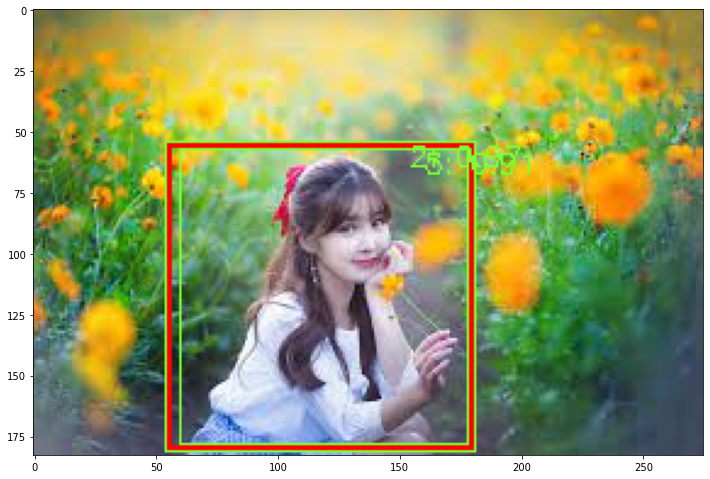

In [17]:
img = cv2.imread('people.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('img shape:', img.shape)

green_rgb = (125, 255, 51)
cand_rects = [cand['rect'] for cand in regions if cand['size'] > 3000]
gt_box = [55, 55, 180, 180]
img_rgb = cv2.rectangle(img_rgb, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), color=red, thickness=2)

for index, cand_box in enumerate(cand_rects):
    
    cand_box = list(cand_box)
    cand_box[2] += cand_box[0]
    cand_box[3] += cand_box[1]
    
    iou = compute_iou(cand_box, gt_box)
    
    if iou > 0.8:
        print('index:', index, "iou:", iou, 'rectangle:',(cand_box[0], cand_box[1], cand_box[2], cand_box[3]) )
        cv2.rectangle(img_rgb, (cand_box[0], cand_box[1]), (cand_box[2], cand_box[3]), color=green_rgb, thickness=1)
        text = "{}: {:.2f}".format(index, iou)
        cv2.putText(img_rgb, text, (cand_box[0]+ 100, cand_box[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color=green_rgb, thickness=1)
    
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()
    